In [ ]:
!pip install transformers seaborn datasets evaluate rouge_score nltk numpy spacy lexrank

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/NLP_course_work/archive.zip" /content/archive.zip
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: lenta-ru-news.csv       


In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from lexrank import LexRank
from spacy.lang.ru.stop_words import STOP_WORDS

import nltk
from nltk.tokenize import sent_tokenize
import numpy as np
from datasets import Dataset
from datasets import load_dataset, load_metric
from sklearn.model_selection import train_test_split
import transformers
from transformers import (
    AutoConfig,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    HfArgumentParser,
    MBart50TokenizerFast,
    MBartTokenizer,
    MBartTokenizerFast,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    set_seed,
)
import evaluate

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

#### Загрузка данных и предварительный анализ

In [ ]:
data_news = pd.read_csv('/content/lenta-ru-news.csv')
data_news.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


In [ ]:
data_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800975 entries, 0 to 800974
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     800975 non-null  object
 1   title   800975 non-null  object
 2   text    800970 non-null  object
 3   topic   738973 non-null  object
 4   tags    773756 non-null  object
 5   date    800975 non-null  object
dtypes: object(6)
memory usage: 36.7+ MB


In [ ]:
# Удалим новости, которые не содержат текста
data_news.dropna(axis=0, how='any', subset=['text'], inplace=True)

# Уберем \xa0 из данных и приведем к нижнему регистру
data_news['title'] = data_news['title'].str.split().str.join(' ').apply(lambda x: x.lower())

# Приведем данные к нижнему регистру
data_news['text'] = data_news['text'].apply(lambda x: x.lower())

In [ ]:
# Оставим новости 21 века
data_news['date'] = pd.to_datetime(data_news['date'])
data_news = data_news[data_news['date'] >= '2000-1-1']
data_news.head()

,url,title,text,topic,tags,date
3086,https://lenta.ru/news/2000/01/01/y2k/,ошибка 2000: ничего не случилось,вопреки апокалиптическим прогнозам американски...,Интернет и СМИ,Все,2000-01-01
3087,https://lenta.ru/news/2000/01/01/likvidacia/,в новогоднюю ночь ликвидировано семь полевых к...,"7 полевых командиров боевиков, в том числе, за...",Россия,Все,2000-01-01
3088,https://lenta.ru/news/2000/01/01/putin/,путин: в составе правительства возможны изменения,ранее запланированная на полдень 2 января встр...,Россия,Все,2000-01-01
3089,https://lenta.ru/news/2000/01/02/patriarch/,патриарх всея руси прибыл на святую землю,2 января в израиль прибыл патриарх московский ...,Россия,Все,2000-01-02
3090,https://lenta.ru/news/2000/01/02/yeltsin/,фонду ельцина выделят помещение в кремле,борис ельцин намерен организовать собственный ...,Россия,Все,2000-01-02


#### Изучение и обработка количественных признаков

In [ ]:
data_news['length_title'] = data_news['title'].apply(lambda x: len(x.split()))
data_news['length_text'] = data_news['text'].apply(lambda x: len(x.split()))
data_news[['length_title', 'length_text']].describe()

,length_title,length_text
count,797884.000000,797884.000000
mean,7.496639,180.315358
std,1.801768,73.651864
min,1.000000,1.000000
25%,6.000000,133.000000
50%,7.000000,170.000000
75%,9.000000,216.000000
max,18.000000,8092.000000


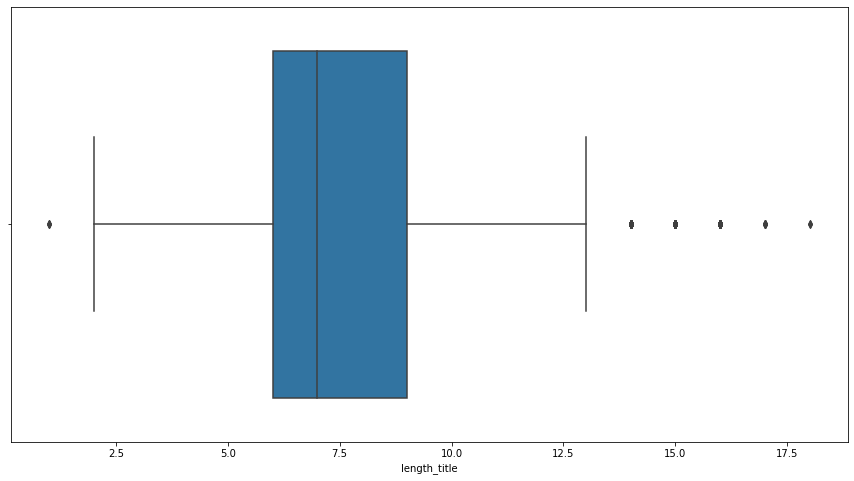

In [ ]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='length_title', data=data_news)

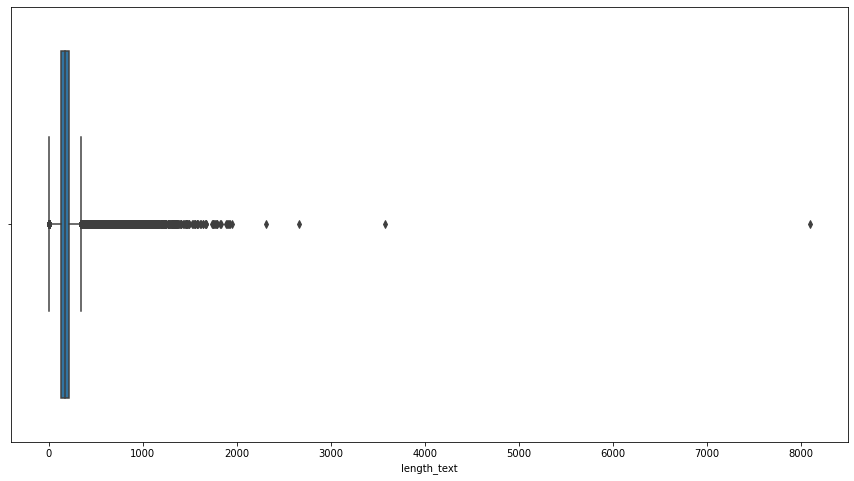

In [ ]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='length_text', data=data_news)

In [ ]:
print('нижняя граница: ', data_news.length_text.quantile(0.01), ', верхняя граница: ', data_news.length_text.quantile(0.99))

нижняя граница:  56.0 , верхняя граница:  395.0


In [ ]:
# Удалим новости, которые содержат слишком маленький, либо слишком большой текст
data_news['length_text'] = data_news.length_text.clip(lower=data_news.length_text.quantile(0.01), 
                                                      upper=data_news.length_text.quantile(0.99))

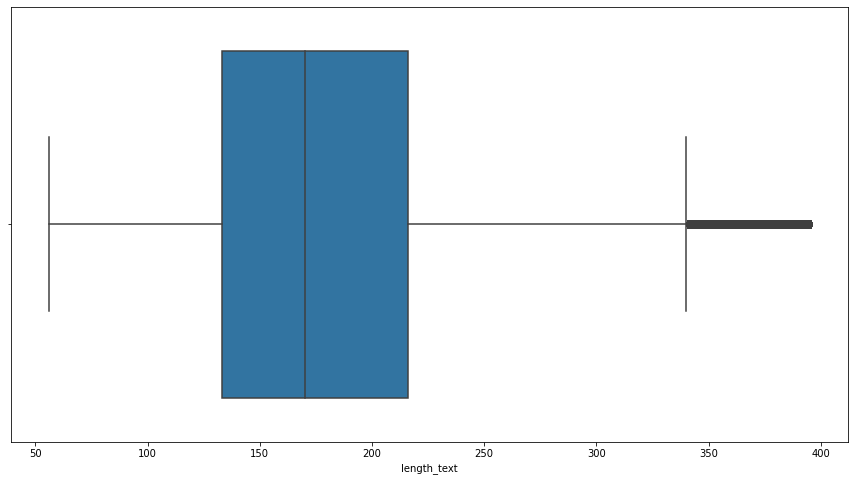

In [ ]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='length_text', data=data_news)

#### Изучение категориальных и интервальных признаков

In [ ]:
data_news['tags'].value_counts(normalize=True)

Все               0.584790
Политика          0.052832
Общество          0.045677
Украина           0.029225
Происшествия      0.025725
                    ...   
Мировой опыт      0.000008
Нацпроекты        0.000008
Вооружение        0.000004
Инновации         0.000001
69-я параллель    0.000001
Name: tags, Length: 94, dtype: float64

In [ ]:
print('10 самых популярных тегов включают в себя: ', data_news['tags'].value_counts(normalize=True).head(10).values.sum() * 100., '%')
data_news['tags'].value_counts(normalize=True).head(10)

10 самых популярных тегов включают в себя:  81.59745155158208 %


Все             0.584790
Политика        0.052832
Общество        0.045677
Украина         0.029225
Происшествия    0.025725
Госэкономика    0.020081
Футбол          0.019774
Кино            0.013910
Интернет        0.012092
Бизнес          0.011868
Name: tags, dtype: float64

In [ ]:
# Количество опубликованных новостей в год
data_news['year'] = pd.DatetimeIndex(data_news['date']).year
data_news['year'].value_counts()

2016    63107
2019    59729
2017    58792
2009    51343
2008    50389
2012    46047
2011    44822
2015    44766
2010    44587
2018    43951
2013    43297
2014    38075
2007    36029
2006    35960
2005    30718
2004    24386
2002    22179
2001    21974
2003    21557
2000    16176
Name: year, dtype: int64

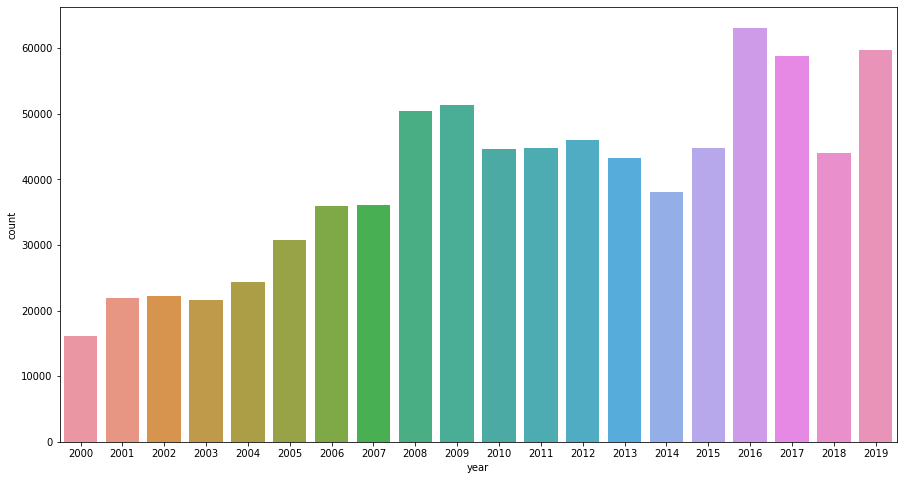

In [ ]:
plt.figure(figsize=(15, 8))
sns.countplot(x='year', data=data_news)

In [ ]:
X_train, X_test_and_eval = train_test_split(data_news[['title', 'text']].sample(n=40_000, random_state=42), test_size=10_000, random_state=42)
X_eval, X_test = train_test_split(X_test_and_eval, test_size=5_000, random_state=42)
X_train.to_csv('train.csv', index=False, encoding='utf-8')
X_eval.to_csv('eval.csv', index=False, encoding='utf-8')
X_test.to_csv('test.csv', index=False, encoding='utf-8')

In [ ]:
!cp /content/train.csv "/content/drive/MyDrive/NLP_course_work/train.csv"
!cp /content/eval.csv "/content/drive/MyDrive/NLP_course_work/eval.csv"
!cp /content/test.csv "/content/drive/MyDrive/NLP_course_work/test.csv"

#### Baseline

In [ ]:
# Метрика
metric = evaluate.load("rouge")

def postprocess_text(preds, labels):
  preds = [pred.strip() for pred in preds]
  labels = [label.strip() for label in labels]

  # rougeLSum ожидает новую строку после каждого предложения
  preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
  labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

  return preds, labels

def compute_metrics(preds, labels):
  preds, labels = postprocess_text(preds, labels)

  result = metric.compute(predictions=preds, references=labels, tokenizer=lambda x: x.split())
  result = {k: round(v * 100, 4) for k, v in result.items()}

  return result

In [ ]:
lxr = LexRank(X_test.values, stopwords=STOP_WORDS)
X_test_summarize = X_test['text'].apply(lambda x: lxr.get_summary(sent_tokenize(x), summary_size=1)[0][:-1])

In [ ]:
result = compute_metrics(X_test_summarize, X_test['title'].apply(lambda x: x.lower()))
result

{'rouge1': 12.9408, 'rouge2': 3.9882, 'rougeL': 11.9508, 'rougeLsum': 11.9381}

In [ ]:
# Пример суммаризации 1
print('Оригинальный заголовок: ', X_test.iloc[0]['title'])
print('Текст: ', X_test.iloc[0]['text'])
print('Сгенерированный заголовок: ', X_test_summarize.iloc[0])

Оригинальный заголовок:  "макдоналдс" у "третьяковской" "заминировали"
Текст:  в здании "макдоналдса" около станции метро "третьяковская" ищут взрывное устройство. по сообщению корреспондента ленты.ру, около полуночи всех находящихся в здании, где кроме "макдоналдса" расположены офисы, попросили покинуть помещение. сотрудники милиции сообщили, что поступил сигнал о заложенном в здании взрывном устройстве. около здания выставлено милицейское оцепление, выход и вход на станцию метро "третьяковская" закрыт. на место происшествия прибыли представители всех городских спецслужб. здание и прилегающую площадь осматривают кинологи с собаками и специалисты взрывотехники. корреспондента ленты.ру, пытавшегося подойти ближе к зданию "макдоналдс", сотрудник милиции попросил немедленно отойти подальше, мотивировав свою просьбу тем, что "в любую минуту может произойти взрыв".
Сгенерированный заголовок:  в здании "макдоналдса" около станции метро "третьяковская" ищут взрывное устройство


In [ ]:
# Пример суммаризации 2
print('Оригинальный заголовок: ', X_test.iloc[1]['title'])
print('Текст: ', X_test.iloc[1]['text'])
print('Сгенерированный заголовок: ', X_test_summarize.iloc[1])

Оригинальный заголовок:  в израильской тюрьме убили устроившего мятеж американца
Текст:  израильская полиция застрелила 34-летнего американца самюэля шейнбейна, устроившего перестрелку в помещении тюрьмы, где отбывал наказание. об этом сообщает associated press. в операции по нейтрализации шейнбейна принимал отряд по борьбе с терроризмом. спецназ был вызван на место происшествия после того, как шейнбейн завладел оружием одного из тюремных охранников, выстрелил в трех тюремщиков и забаррикадировался на территории тюрьмы. после того, как на место прибыл отряд спецназа, шейнбейн вновь открыл огонь, но был застрелен ответными выстрелами со стороны полиции. никто из полицейских не пострадал. двое из трех тюремщиков, в которых стрелял шейнбейн, получили тяжелые ранения. самюэль шейнбейн отбывал в израильской тюрьме 24-летний срок за убийство, совершенное в 1997 году в штате мэриленд, сша. после совершения убийства американец еврейского происхождения, имевший право на израильское гражданство,

#### Fine-tuning модели mbart-large-cc25

In [ ]:
!cp "/content/drive/MyDrive/NLP_course_work/train.csv" /content/train.csv
!cp "/content/drive/MyDrive/NLP_course_work/eval.csv" /content/eval.csv
!cp "/content/drive/MyDrive/NLP_course_work/test.csv" /content/test.csv

In [ ]:
SEED = 3
lang = 'ru_RU'
set_seed(SEED)

In [ ]:
dataset = load_dataset("csv", data_files={'train': 'train.csv', 'eval': 'eval.csv', 'test': 'test.csv'})

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-4dc0a222be50a3db/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset['train'][0]

{'title': 'российская нефть ценится в мире все ниже',
 'text': 'доходы россии от продажи нефти растут заметно медленнее, чем доходы других стран. как сообщается на сайте ежедневной газеты "ведомости", к 11 октября разница между сортом brent и российской нефтью марки urals достигла 8 долларов за баррель — рекордный разрыв за последние 10 лет. если бы цена urals не отдалилась от brent, россия получила бы на 3 миллиарда долларов больше. 11 октября стоимость ноябрьских фьючерсов на эталонный сорт brent на лондонской бирже впервые перешагнула 50 долларов за баррель. 12 октября она составила 50,43 доллара за баррель. в сша уровень в 50 долларов пройден уже давно. а вот российская нефть марки urals, по данным международного агентства reuters, 12 октября продавалась за 43,82 доллара за баррель. причем разрыв в ценах в последнее время заметно увеличился. к 11 октября он достиг рекордного за последние 10 лет значения - 8 долларов за баррель. тогда как среднее за последние 10 лет значение этого р

In [ ]:
model_name = "facebook/mbart-large-cc25"

config = transformers.AutoConfig.from_pretrained(model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name, config=config)

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

In [ ]:
model.config.decoder_start_token_id = tokenizer.convert_tokens_to_ids(lang)

In [ ]:
tokenizer.src_lang = lang
tokenizer.tgt_lang = lang

# Для mbart нужен токен языка
forced_bos_token_id = (tokenizer.lang_code_to_id[lang])

model.config.forced_bos_token_id = forced_bos_token_id

In [ ]:
text_column = 'text'
summary_column = 'title'

In [ ]:
max_source_length = 600
max_target_length = 60
padding = 'max_length'
ignore_pad_token_for_loss = True

In [ ]:
def preprocess_function(examples):
  inputs, targets = [], []

  for i in range(len(examples[text_column])):
      if examples[text_column][i] and examples[summary_column][i]:
          inputs.append(examples[text_column][i])
          targets.append(examples[summary_column][i])

  model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

  labels = tokenizer(text_target=targets, max_length=max_target_length, padding=padding, truncation=True)

  # Для игнорирования паддинга в loss
  if padding == "max_length" and ignore_pad_token_for_loss:
      labels["input_ids"] = [
          [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
      ]

  model_inputs["labels"] = labels["input_ids"]

  return model_inputs

In [ ]:
train_dataset = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=2,
    remove_columns=['title', 'text'],
    )

#1:   0%|          | 0/15 [00:00<?, ?ba/s]

#0:   0%|          | 0/15 [00:00<?, ?ba/s]

#1:   0%|          | 0/3 [00:00<?, ?ba/s]

#0:   0%|          | 0/3 [00:00<?, ?ba/s]

#0:   0%|          | 0/3 [00:00<?, ?ba/s]

#1:   0%|          | 0/3 [00:00<?, ?ba/s]

In [ ]:
# Data collator
label_pad_token_id = -100 
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)

In [ ]:
# Метрика
metric = evaluate.load("rouge")

In [ ]:
def postprocess_text(preds, labels):
  preds = [pred.strip() for pred in preds]
  labels = [label.strip() for label in labels]

  # rougeLSum ожидает новую строку после каждого предложения
  preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
  labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

  return preds, labels

In [ ]:
def compute_metrics(eval_preds):
  preds, labels = eval_preds
  decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
  if ignore_pad_token_for_loss:
      labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
  decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

  result = metric.compute(predictions=decoded_preds, references=decoded_labels, tokenizer=lambda x: x.split())
  result = {k: round(v * 100, 4) for k, v in result.items()}
  prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
  result["gen_len"] = np.mean(prediction_lens)
  return result

In [ ]:
training_args = Seq2SeqTrainingArguments(
    evaluation_strategy='epoch',
    num_train_epochs=3,
    output_dir='test_trainer',
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    fp16=True,
    optim="adafactor",
    predict_with_generate=True
    )

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset['train'],
    eval_dataset=train_dataset['eval'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
    )

train_result = trainer.train()

Using cuda_amp half precision backend
***** Running training *****
  Num examples = 30000
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 8
  Total optimization steps = 2811
  Number of trainable parameters = 610851840
You're using a MBartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
0,1.938100,1.285532,34.808800,17.808800,32.907900,32.902700,20.571800
1,1.038900,1.222873,35.582200,18.410300,33.631100,33.635700,21.585000
2,0.744700,1.251436,35.794900,18.600500,33.828500,33.834800,21.401400


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test_trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test_trainer/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 4
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test_trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test_trainer/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to test_trainer/checkpoint-1500
Configuration saved in test_trainer/checkpoint-1500/config.json
Model weights saved in test_trainer/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in test_t

In [ ]:
trainer.save_model('/content/drive/MyDrive/NLP_course_work')

Saving model checkpoint to /content/drive/MyDrive/NLP_course_work
Configuration saved in /content/drive/MyDrive/NLP_course_work/config.json
Model weights saved in /content/drive/MyDrive/NLP_course_work/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/NLP_course_work/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/NLP_course_work/special_tokens_map.json


#### Оценка качества настроенного mBART на тестовом наборе данных

In [ ]:
predict_results = trainer.predict(
    train_dataset['test'],
    metric_key_prefix="predict",
    max_length=max_target_length,
    num_beams=3
)
metrics = predict_results.metrics

***** Running Prediction *****
  Num examples = 5000
  Batch size = 4


In [ ]:
metrics

{'predict_loss': 1.2291582822799683,
 'predict_rouge1': 35.9931,
 'predict_rouge2': 18.6076,
 'predict_rougeL': 34.1661,
 'predict_rougeLsum': 34.1627,
 'predict_gen_len': 21.0768,
 'predict_runtime': 1442.1832,
 'predict_samples_per_second': 3.467,
 'predict_steps_per_second': 0.867}

In [ ]:
predictions = []
if trainer.is_world_process_zero():
  if training_args.predict_with_generate:
    predictions = tokenizer.batch_decode(
        predict_results.predictions, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    predictions = [pred.strip() for pred in predictions]

In [ ]:
output_prediction_file = "generated_predictions.txt"
with open(output_prediction_file, "w") as writer:
  writer.write("\n".join(predictions))

In [ ]:
print('оригинальный заголовок: ', dataset['test'][0]['title'])
print('предсказанный заголовок: ', predictions[0])

оригинальный заголовок:  бабочку хофштадтера впервые «поймали» вне магнитного поля
предсказанный заголовок:  бабочку хофштадтера впервые продемонстрировали в магнитном поле


In [ ]:
print('оригинальный заголовок: ', dataset['test'][1]['title'])
print('предсказанный заголовок: ', predictions[1])

оригинальный заголовок:  свидетель ограбления поймал преступника
предсказанный заголовок:  свидетелю ограбления в хабаровском крае удалось задержать преступника


In [ ]:
print('оригинальный заголовок: ', dataset['test'][2]['title'])
print('предсказанный заголовок: ', predictions[2])

оригинальный заголовок:  youtube занялся гражданской журналистикой
предсказанный заголовок:  youtube запустил сервис видеохостинга для сми


In [ ]:
print('оригинальный заголовок: ', dataset['test'][3]['title'])
print('предсказанный заголовок: ', predictions[3])

оригинальный заголовок:  минздрав пообещал заменить импортные лекарства безболезненно для пациентов
предсказанный заголовок:  минздрав рассказал о внедрении новой методики перевода пациентов с зарубежных лекарств на российские аналоги
